In [1]:
from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder.appName("BankChurnersAnalysis").getOrCreate()
df = spark.read.csv("BankChurners.csv", header=True, inferSchema=True)


In [2]:
df.show(10)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------

In [3]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+
|CLIENTNUM|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|
+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--

In [4]:
columns_values = ["Attrition_Flag", "Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]

for col_name in columns_values:
    print(f"Unique values in column '{col_name}':")
    df.select(col_name).distinct().show()

Unique values in column 'Attrition_Flag':
+-----------------+
|   Attrition_Flag|
+-----------------+
|Existing Customer|
|Attrited Customer|
+-----------------+

Unique values in column 'Gender':
+------+
|Gender|
+------+
|     F|
|     M|
+------+

Unique values in column 'Education_Level':
+---------------+
|Education_Level|
+---------------+
|    High School|
|        Unknown|
|     Uneducated|
|  Post-Graduate|
|      Doctorate|
|       Graduate|
|        College|
+---------------+

Unique values in column 'Marital_Status':
+--------------+
|Marital_Status|
+--------------+
|       Unknown|
|       Married|
|      Divorced|
|        Single|
+--------------+

Unique values in column 'Income_Category':
+---------------+
|Income_Category|
+---------------+
|        $120K +|
|    $60K - $80K|
|   $80K - $120K|
|        Unknown|
|    $40K - $60K|
| Less than $40K|
+---------------+

Unique values in column 'Card_Category':
+-------------+
|Card_Category|
+-------------+
|     Platinum

In [5]:
from pyspark.ml.feature import StringIndexer

columns_encoded = ["Attrition_Flag", "Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]

for col_name in columns_encoded:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    model = indexer.fit(df)

    mapping = model.labels
    print(f"Mapping for column '{col_name}':")
    for index, label in enumerate(mapping):
        print(f"Index {index}: {label}")
    print("\n")


Mapping for column 'Attrition_Flag':
Index 0: Existing Customer
Index 1: Attrited Customer


Mapping for column 'Gender':
Index 0: F
Index 1: M


Mapping for column 'Education_Level':
Index 0: Graduate
Index 1: High School
Index 2: Unknown
Index 3: Uneducated
Index 4: College
Index 5: Post-Graduate
Index 6: Doctorate


Mapping for column 'Marital_Status':
Index 0: Married
Index 1: Single
Index 2: Unknown
Index 3: Divorced


Mapping for column 'Income_Category':
Index 0: Less than $40K
Index 1: $40K - $60K
Index 2: $80K - $120K
Index 3: $60K - $80K
Index 4: Unknown
Index 5: $120K +


Mapping for column 'Card_Category':
Index 0: Blue
Index 1: Silver
Index 2: Gold
Index 3: Platinum




In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

columns_to_encode = ["Attrition_Flag", "Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]

for col_name in columns_to_encode:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
    df = indexer.fit(df).transform(df)
    df = df.drop(col_name).withColumnRenamed(f"{col_name}_index", col_name)

df.show()


+---------+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+------+---------------+--------------+---------------+-------------+
|CLIENTNUM|Customer_Age|Dependent_count|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Attrition_Flag|Gender|Education_Level|Marital_Status|Income_Category|Card_Category|
+---------+------------+---------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+--------------+------+------

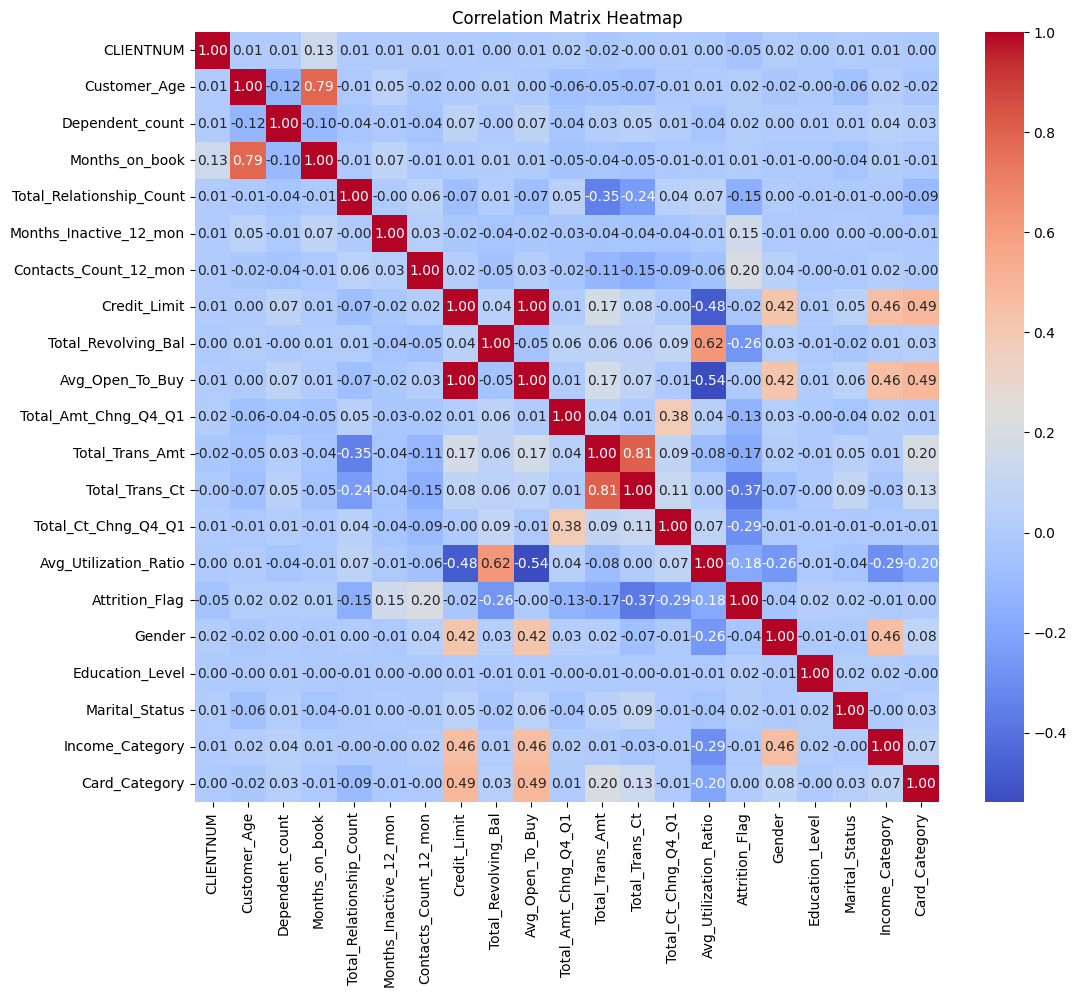

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = df.columns

assembler = VectorAssembler(inputCols=corr_cols, outputCol="features")
vector_df = assembler.transform(df).select("features")

corr_matrix = Correlation.corr(vector_df, "features").head()[0].toArray()

corr_df = pd.DataFrame(corr_matrix, columns=corr_cols, index=corr_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

feature_cols = ["Total_Revolving_Bal", "Total_Trans_Amt", "Total_Trans_Ct", "Customer_Age", "Credit_Limit"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_data = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaled_data = scaler.fit(assembled_data).transform(assembled_data)

kmeans = KMeans(k=6, seed=1, featuresCol="scaledFeatures", predictionCol="segment")
model = kmeans.fit(scaled_data)
segmented_data = model.transform(scaled_data)

segmented_data.groupBy("segment").count().show()

+-------+-----+
|segment|count|
+-------+-----+
|      1|  786|
|      3| 1122|
|      5| 2520|
|      4| 2106|
|      2| 1427|
|      0| 2166|
+-------+-----+



<ipython-input-9-c130219239fa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segment', y='count', data=segment_counts, palette='Set1')


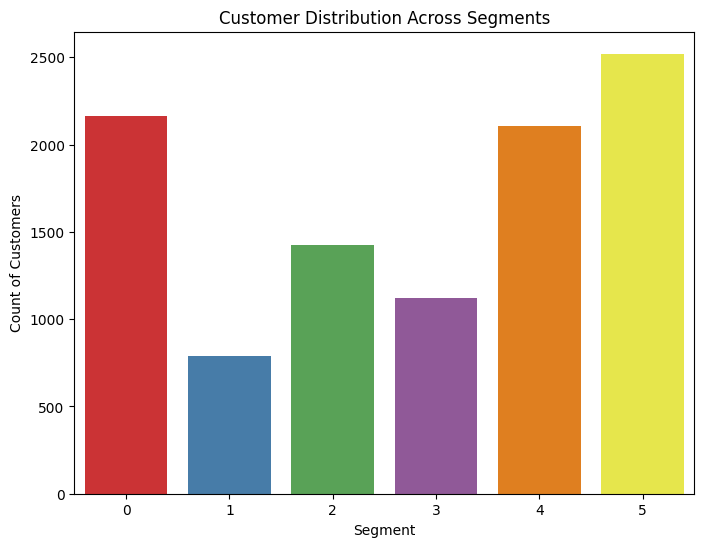

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

segment_counts = segmented_data.groupBy("segment").count().toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(x='segment', y='count', data=segment_counts, palette='Set1')

plt.xlabel('Segment')
plt.ylabel('Count of Customers')
plt.title('Customer Distribution Across Segments')

plt.show()


<ipython-input-10-b5c6359230c6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='segment', y='Total_Revolving_Bal', data=pandas_df, palette='Set1')


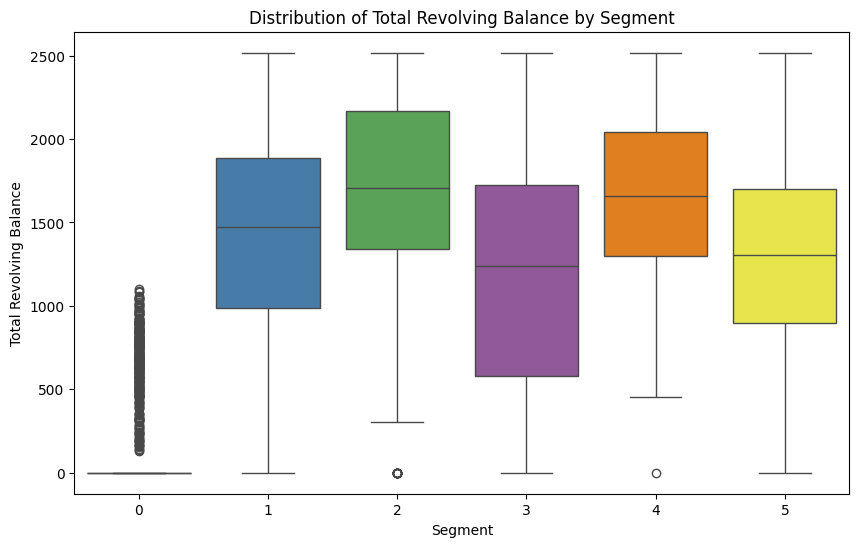

<ipython-input-10-b5c6359230c6>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='segment', y='Total_Trans_Amt', data=pandas_df, palette='Set1')


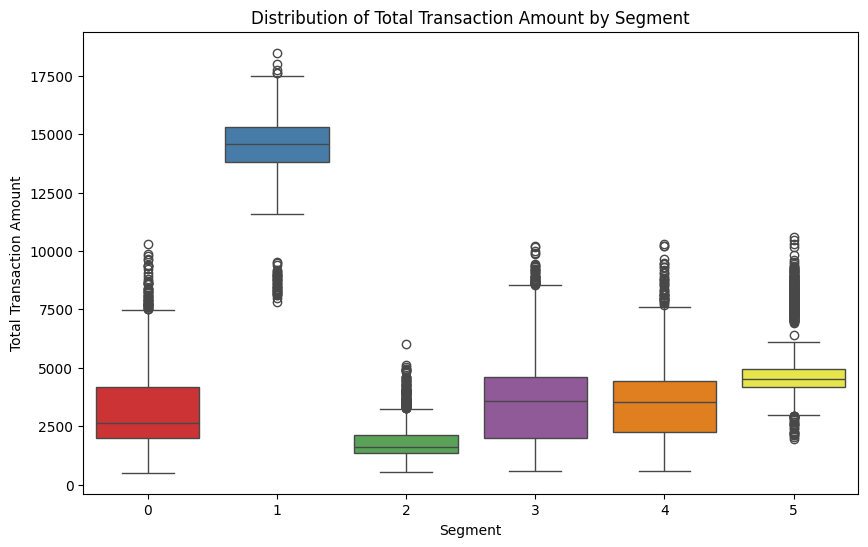

<ipython-input-10-b5c6359230c6>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='segment', y='Total_Trans_Ct', data=pandas_df, palette='Set1')


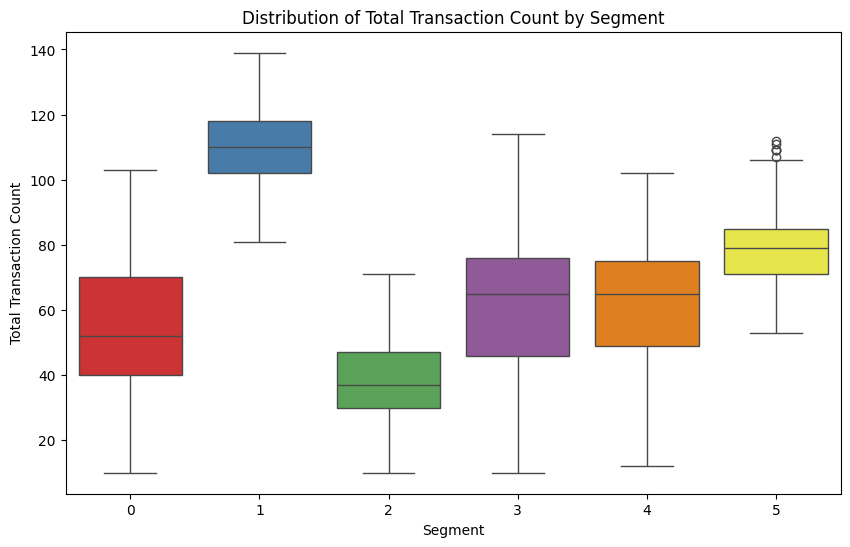

<ipython-input-10-b5c6359230c6>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='segment', y='Customer_Age', data=pandas_df, palette='Set1')


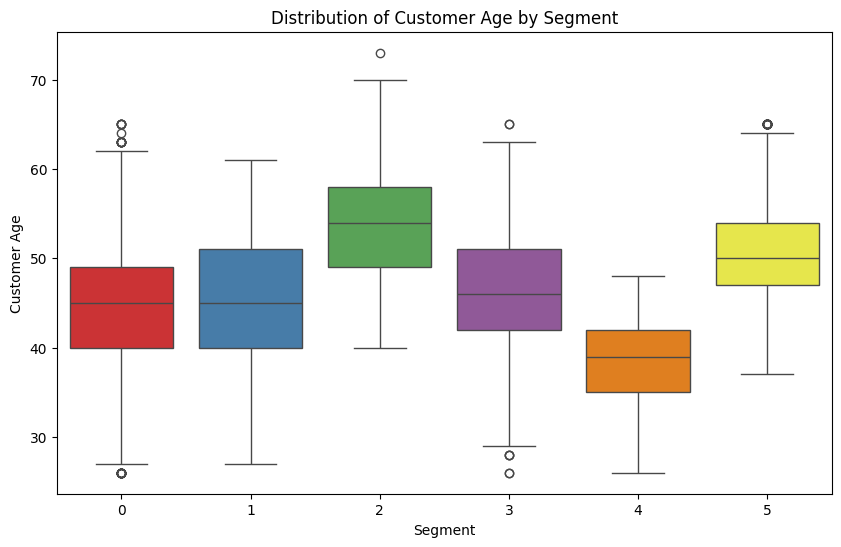

<ipython-input-10-b5c6359230c6>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='segment', y='Credit_Limit', data=pandas_df, palette='Set1')


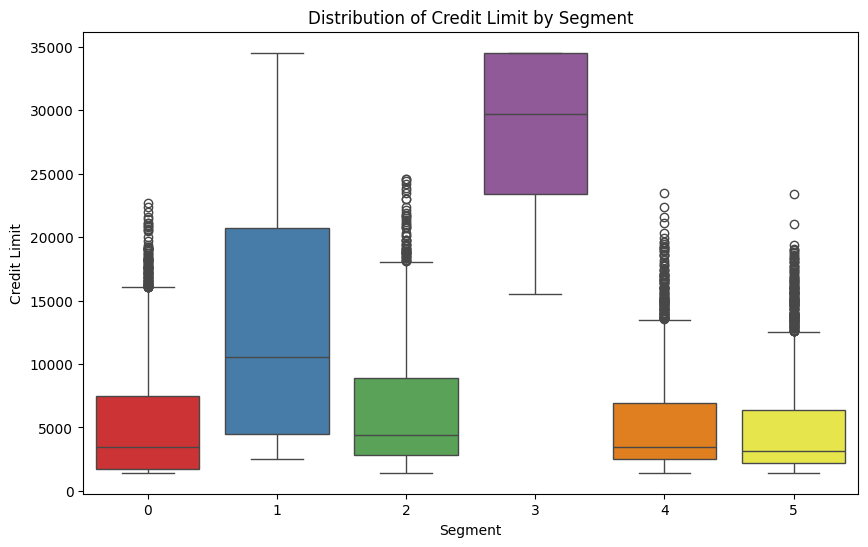

In [10]:
pandas_df = segmented_data.select("segment", "Total_Revolving_Bal", "Total_Trans_Amt",
                                  "Total_Trans_Ct", "Customer_Age", "Credit_Limit").toPandas()

plt.figure(figsize=(10,6))
sns.boxplot(x='segment', y='Total_Revolving_Bal', data=pandas_df, palette='Set1')
plt.title('Distribution of Total Revolving Balance by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Revolving Balance')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='segment', y='Total_Trans_Amt', data=pandas_df, palette='Set1')
plt.title('Distribution of Total Transaction Amount by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Transaction Amount')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='segment', y='Total_Trans_Ct', data=pandas_df, palette='Set1')
plt.title('Distribution of Total Transaction Count by Segment')
plt.xlabel('Segment')
plt.ylabel('Total Transaction Count')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='segment', y='Customer_Age', data=pandas_df, palette='Set1')
plt.title('Distribution of Customer Age by Segment')
plt.xlabel('Segment')
plt.ylabel('Customer Age')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='segment', y='Credit_Limit', data=pandas_df, palette='Set1')
plt.title('Distribution of Credit Limit by Segment')
plt.xlabel('Segment')
plt.ylabel('Credit Limit')
plt.show()


In [11]:
from pyspark.sql import functions as F

for col in feature_cols:
    print(f"Descriptive statistics for {col} by segment:")
    segmented_data.groupBy("segment").agg(
        F.mean(col).alias("mean"),
        F.stddev(col).alias("stddev"),
        F.min(col).alias("min"),
        F.max(col).alias("max")
    ).show()

Descriptive statistics for Total_Revolving_Bal by segment:
+-------+------------------+------------------+---+----+
|segment|              mean|            stddev|min| max|
+-------+------------------+------------------+---+----+
|      1|1371.2226463104325| 724.8169371666813|  0|2517|
|      3|  1156.24064171123| 784.4274985426524|  0|2517|
|      5|            1271.9| 636.6817264551461|  0|2517|
|      4|1673.1728395061727|502.44590310972137|  0|2517|
|      2|1717.2382620882972| 557.8746176820738|  0|2517|
|      0|102.19113573407202|253.64019438520137|  0|1103|
+-------+------------------+------------------+---+----+

Descriptive statistics for Total_Trans_Amt by segment:
+-------+------------------+------------------+----+-----+
|segment|              mean|            stddev| min|  max|
+-------+------------------+------------------+----+-----+
|      1|14398.306615776082|1676.8763298503045|7821|18484|
|      3|3905.7834224598932|2258.8954514223155| 597|10201|
|      5| 4871.57420

In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from scipy.stats import ttest_rel

baseline_features = ["Total_Revolving_Bal", "Total_Trans_Amt", "Total_Trans_Ct", "Customer_Age", "Marital_Status"]
alternative_features = baseline_features + ["Credit_Limit", "Avg_Open_To_Buy", "Total_Ct_Chng_Q4_Q1"]

def run_kmeans(features, data, k=6):
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    assembled = assembler.transform(data)

    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
    scaled_data = scaler.fit(assembled).transform(assembled)

    kmeans = KMeans(k=k, seed=42, featuresCol="scaledFeatures")
    model = kmeans.fit(scaled_data)

    return model.summary.trainingCost

def compute_fold_cohesion(data, features, num_folds=5, k=6):
    fold_scores = []
    for i in range(num_folds):
        train_data, test_data = data.randomSplit([0.8, 0.2], seed=42 + i)
        fold_score = run_kmeans(features, train_data, k)
        fold_scores.append(fold_score)
    return fold_scores

baseline_folds = compute_fold_cohesion(df, baseline_features)
alternative_folds = compute_fold_cohesion(df, alternative_features)

t_stat, p_value = ttest_rel(baseline_folds, alternative_folds)

print(f"Baseline Cohesion: {baseline_folds}")
print(f"Alternative Cohesion: {alternative_folds}")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("Reject H_0: Alternative features improve clustering cohesion.")
else:
    print("Fail to reject H_0: No significant improvement with alternative features.")

Baseline Cohesion: [16690.251615458037, 16706.950328329876, 16405.58054799011, 16575.379319399166, 16437.20517791782]
Alternative Cohesion: [33873.60313150201, 33912.51470252063, 34874.88642016123, 33883.13143720661, 33683.14819254858]
T-Statistic: -70.59729605015414, P-Value: 2.412227604977211e-07
Reject H_0: Alternative features improve clustering cohesion.


In [12]:
df.groupBy("Card_Category").count().orderBy("count", ascending=False).show()


+-------------+-----+
|Card_Category|count|
+-------------+-----+
|          0.0| 9436|
|          1.0|  555|
|          2.0|  116|
|          3.0|   20|
+-------------+-----+



<ipython-input-13-f5e8da7efaf4>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Card_Category', y='count', data=card_count_pd, palette='Set1')


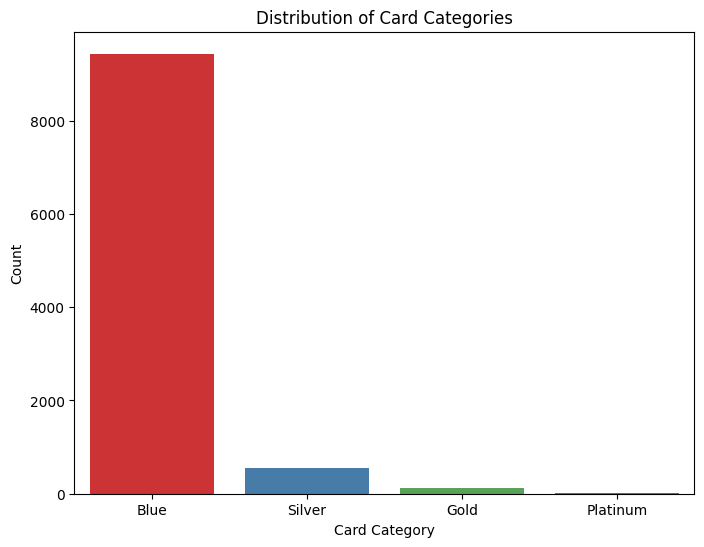

In [13]:
card_count = df.groupBy("Card_Category").count().orderBy("count", ascending=False)

card_count_pd = card_count.toPandas()

card_mapping = {0: 'Blue', 1: 'Silver', 2: 'Gold', 3: 'Platinum'}

card_count_pd["Card_Category"] = card_count_pd["Card_Category"].map(card_mapping)

plt.figure(figsize=(8, 6))
sns.barplot(x='Card_Category', y='count', data=card_count_pd, palette='Set1')
plt.title('Distribution of Card Categories')
plt.xlabel('Card Category')
plt.ylabel('Count')
plt.show()


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

feature_cols = [col for col in df.columns if col not in ["CLIENTNUM", "Attrition_Flag"]]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="Attrition_Flag")

model = lr.fit(train_data)

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_Flag", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.2f}")

predictions.select("Attrition_Flag", "prediction", "probability").show()


Model Accuracy: 0.91
+--------------+----------+--------------------+
|Attrition_Flag|prediction|         probability|
+--------------+----------+--------------------+
|           1.0|       1.0|[0.09143622125821...|
|           0.0|       0.0|[0.99371602416034...|
|           0.0|       0.0|[0.99185476950636...|
|           0.0|       0.0|[0.89909363266643...|
|           0.0|       0.0|[0.98209537658010...|
|           0.0|       0.0|[0.96891117306586...|
|           1.0|       1.0|[0.35635277964593...|
|           0.0|       0.0|[0.99669211121758...|
|           0.0|       0.0|[0.77212579404930...|
|           1.0|       0.0|[0.69299260441329...|
|           1.0|       0.0|[0.72377850955225...|
|           0.0|       0.0|[0.93831910860118...|
|           0.0|       0.0|[0.99027114840748...|
|           0.0|       0.0|[0.79209164326726...|
|           1.0|       1.0|[0.42305527966113...|
|           0.0|       0.0|[0.85241302081398...|
|           0.0|       0.0|[0.99520430289288...|

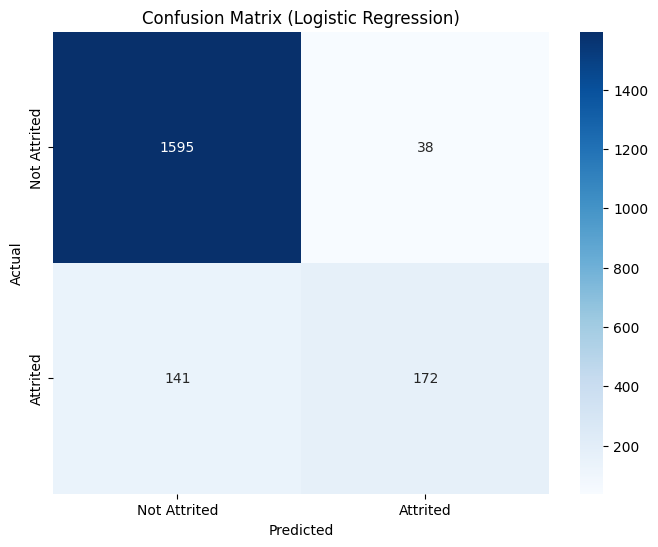

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions_pd = predictions.select("Attrition_Flag", "prediction").toPandas()

cm = confusion_matrix(predictions_pd["Attrition_Flag"], predictions_pd["prediction"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Attrited", "Attrited"], yticklabels=["Not Attrited", "Attrited"])
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

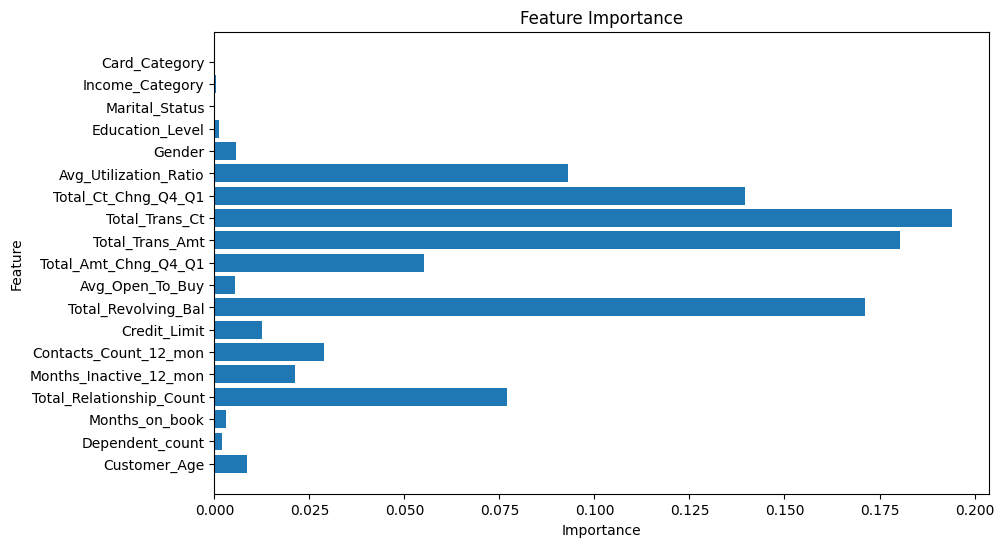

In [16]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="Attrition_Flag")
rf_model = rf.fit(train_data)

feature_importances = rf_model.featureImportances.toArray()

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_cols, feature_importances)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


ROC AUC Score: 0.93


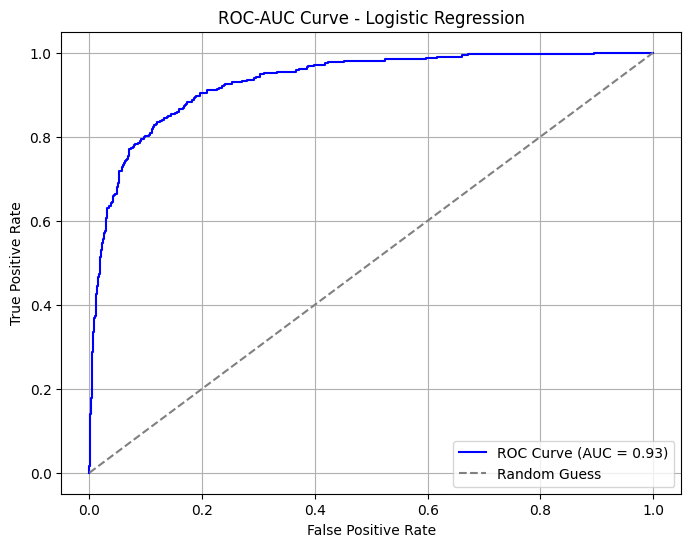

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Flag", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f"ROC AUC Score: {roc_auc:.2f}")

predictions_pd = predictions.select("Attrition_Flag", "probability", "prediction").toPandas()

predictions_pd["prob_positive"] = predictions_pd["probability"].apply(lambda x: x[1])

fpr, tpr, _ = roc_curve(predictions_pd["Attrition_Flag"], predictions_pd["prob_positive"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random Guess")
plt.title("ROC-AUC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()